In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.preprocessing import image_dataset_from_directory

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
BASE_PATH = '/content/gdrive/MyDrive/Luận văn Cao học/Tuberculosis/TB_Chest_Radiography_Database/'

TRAIN_DIR = BASE_PATH + 'train/'
TEST_DIR = BASE_PATH + 'test/'
COLOR_MODE = 'rgb'
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE*5

train_set = image_dataset_from_directory(TRAIN_DIR,
                                            labels='inferred', 
                                            label_mode='int',
                                            color_mode=COLOR_MODE,
                                            batch_size=BATCH_SIZE,
                                            image_size=(IMG_WIDTH, IMG_HEIGHT),
                                            shuffle=True,
                                            seed=123,
                                            validation_split=0.2,
                                            subset='training')

dev_set = image_dataset_from_directory(TRAIN_DIR,
                                            labels='inferred', 
                                            label_mode='int',
                                            color_mode=COLOR_MODE,
                                            batch_size=BATCH_SIZE,
                                            image_size=(IMG_WIDTH, IMG_HEIGHT),
                                            shuffle=True,
                                            seed=123,
                                            validation_split=0.2,
                                            subset='validation')

train_dataset = train_set.cache().prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = dev_set.cache().prefetch(buffer_size=BUFFER_SIZE)

Found 5600 files belonging to 2 classes.
Using 4480 files for training.
Found 5600 files belonging to 2 classes.
Using 1120 files for validation.


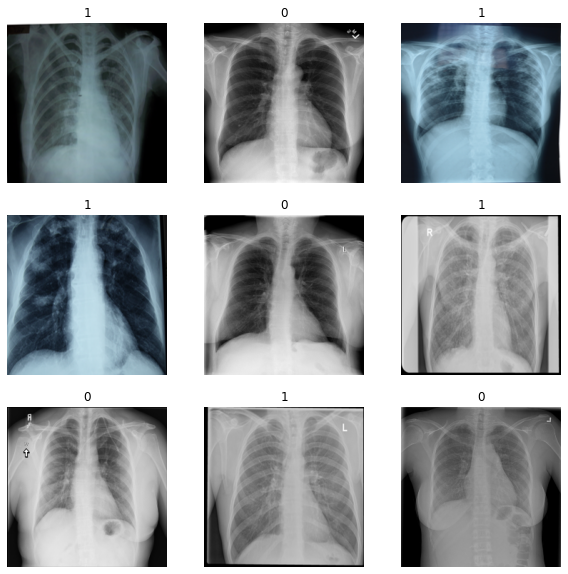

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in dev_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model

In [5]:
!pip install livelossplot

In [6]:
# VGG16

# VGG 16 pre-trained
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense

vgg = VGG16(include_top=False, input_shape=(224, 224, 3))

# breeze all VGG previous layers
for layer in vgg.layers:
	layer.trainable = False

flatten = Flatten()(vgg.layers[-1].output)
fc1 = Dense(128, activation='relu')(flatten)
out = Dense(1, activation='sigmoid')(fc1)

model1 = Model(inputs=vgg.inputs, outputs=out)
model1.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

monitor_val_acc = EarlyStopping(monitor = 'val_loss', 
                                patience = 5)

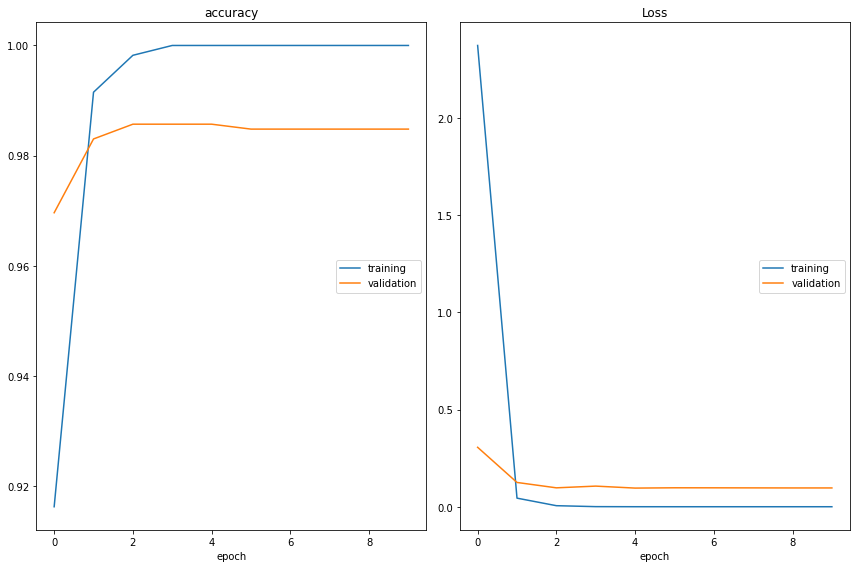

accuracy
	training         	 (min:    0.916, max:    1.000, cur:    1.000)
	validation       	 (min:    0.970, max:    0.986, cur:    0.985)
Loss
	training         	 (min:    0.000, max:    2.373, cur:    0.000)
	validation       	 (min:    0.096, max:    0.306, cur:    0.097)
35/35 [==============================] - 24s 595ms/step - loss: 2.4271e-05 - accuracy: 1.0000 - val_loss: 0.0967 - val_accuracy: 0.9848


In [8]:
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model1.fit(train_set, 
           epochs = 200,
           batch_size=1024,
           callbacks=[PlotLossesKeras(), monitor_val_acc],
           validation_data = dev_set)

In [9]:
model1.save('/content/gdrive/MyDrive/Luận văn Cao học/Tuberculosis/Models/Models for TB Chest Radiograph/model_vgg16.h5')